# **Regularización en Regresión Logística**

Cuando se tienen múltiples variables en un modelo de regresión logística, puede ser útil encontrar un conjunto reducido de variables que dé como resultado un modelo de rendimiento óptimo.

La regresión logística penalizada impone una penalización al modelo logístico por tener demasiadas variables. El resultado es que los coeficientes de las variables menos contributivas se reducen a cero. Esto también se conoce como regularización.

Entre las regresiones penalizadas más utilizadas se incluyen:

*   **regresión ridge**: las variables con menor contribución tienen sus coeficientes próximos a cero. Sin embargo, todas las variables se incorporan al modelo. Esto es útil cuando todas las variables deben incorporarse al modelo de acuerdo con el conocimiento del dominio.
*   **regresión lasso**: se fuerza a que los coeficientes de algunas variables menos contributivas sean exactamente cero. Sólo se mantienen en el modelo final las variables más significativas.
*   **regresión elástic net**: combinación de la regresión ridge y la regresión lasso. Reduce algunos coeficientes hacia cero (como la regresión ridge) y fija algunos coeficientes exactamente en cero (como la regresión lasso).

Este notebook describe cómo calcular la regresión logística penalizada, tal como la regresión lasso, para seleccionar automáticamente un modelo óptimo que contenga las variables predictoras más contributivas.

In [1]:
install.packages("caret")
install.packages("glmnet")
install.packages("mlbench")

library(tidyverse)
library(caret)
library(glmnet)
library("mlbench")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘RcppEigen’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ d

Conjunto de datos: PimaIndiansDiabetes2 [en el paquete mlbench], para predecir la probabilidad de ser diabético positivo en función de múltiples variables clínicas:

1.   pregnant: Número de veces embarazada
2.   glucose:  Concentración de glucosa en plasma (prueba de tolerancia a la glucosa)
3.   pressure: Presión arterial diastólica (mm Hg)
4.   triceps: Grosor del pliegue cutáneo del tríceps (mm)
5.   insulin: Insulina sérica de 2 horas (mu U/ml)
6.   mass: Índice de masa corporal
7.   pedrigree: función de pedigree de Diabetes
8.   age: Edad (años)
9.   diabetes: Variable de clase (prueba de diabetes)

Dividiremos aleatoriamente los datos en un conjunto de entrenamiento (80% para construir un modelo predictivo) y un conjunto de prueba (20% para evaluar el modelo). Asegúrese de establecer la semilla para la reproductibilidad.

In [2]:
# Load the data and remove NAs
data("PimaIndiansDiabetes2", package = "mlbench")
PimaIndiansDiabetes2 <- na.omit(PimaIndiansDiabetes2)
# Inspect the data
sample_n(PimaIndiansDiabetes2, 3)
# Split the data into training and test set
set.seed(123)
training.samples <- PimaIndiansDiabetes2$diabetes %>%
  createDataPartition(p = 0.8, list = FALSE)
train.data  <- PimaIndiansDiabetes2[training.samples, ]
test.data <- PimaIndiansDiabetes2[-training.samples, ]

,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
190,5,139,80,35,160,31.6,0.361,25,pos
670,9,154,78,30,100,30.9,0.164,45,neg
451,1,82,64,13,95,21.2,0.415,23,neg


In [46]:
table(train.data$diabetes)


neg pos 
210 104 

In [48]:
table(test.data$diabetes)


neg pos 
 52  26 

La función de R model.matrix() ayuda a crear la matriz de predictores y también convierte automáticamente los predictores categóricos en variables ficticias adecuadas, lo que es necesario para la función glmnet().

In [3]:
# Dumy code categorical predictor variables
x <- model.matrix(diabetes~., train.data)[,-1]
# Convert the outcome (class) to a numerical variable
y <- ifelse(train.data$diabetes == "pos", 1, 0)

Utilizaremos la función de R glmnet() [paquete glmnet] para calcular la regresión logística penalizada.

Ajustaremos un primero modelo de regresion logística:

In [86]:
# Fit the model
full.model <- glm(diabetes ~., data = train.data, family = binomial)

# Make predictions - TRAIN
probabilities <- full.model %>% predict(train.data, type = "response")
predicted.classes <- ifelse(probabilities > 0.3, "pos", "neg")
# Model accuracy - TRAIN
observed.classes <- train.data$diabetes
print("ENTRENAMIENTO")
print(confusionMatrix(as.factor(predicted.classes),observed.classes))

# Make predictions - TEST
probabilities <- full.model %>% predict(test.data, type = "response")
predicted.classes <- ifelse(probabilities > 0.3, "pos", "neg")
# Model accuracy - TEST
observed.classes <- test.data$diabetes
print("PRUEBA")
print(confusionMatrix(as.factor(predicted.classes),observed.classes))

[1] "ENTRENAMIENTO"
Confusion Matrix and Statistics

          Reference
Prediction neg pos
       neg 164  17
       pos  46  87
                                          
               Accuracy : 0.7994          
                 95% CI : (0.7507, 0.8422)
    No Information Rate : 0.6688          
    P-Value [Acc > NIR] : 2.089e-07       
                                          
                  Kappa : 0.5769          
                                          
 Mcnemar's Test P-Value : 0.0004192       
                                          
            Sensitivity : 0.7810          
            Specificity : 0.8365          
         Pos Pred Value : 0.9061          
         Neg Pred Value : 0.6541          
             Prevalence : 0.6688          
         Detection Rate : 0.5223          
   Detection Prevalence : 0.5764          
      Balanced Accuracy : 0.8087          
                                          
       'Positive' Class : neg             
          

**x**: matriz de variables predictoras

**y**: la variable de respuesta o resultado, que es una variable binaria.

**familia**: el tipo de respuesta. Utilice «binomial» para una variable de resultado binaria

**alfa**: el parámetro de mezcla de la red elástica. Los valores permitidos son:


*   1: para regresión lasso
*   0: para la regresión ridge
*   un valor entre 0 y 1 (por ejemplo, 0,3) para la regresión elasticnet.

**lambda**: valor numérico que define la cantidad de contracción. Debe ser especificado por el analista.

En la regresión penalizada, debe especificar una lambda constante para ajustar la cantidad de contracción del coeficiente. La mejor lambda para sus datos puede definirse como la lambda que minimiza la tasa de error de predicción de validación cruzada. Esto puede determinarse automáticamente utilizando la función cv.glmnet().

## Regresión LASSO

Hallar el valor óptimo de lambda que minimice el error de validación cruzada

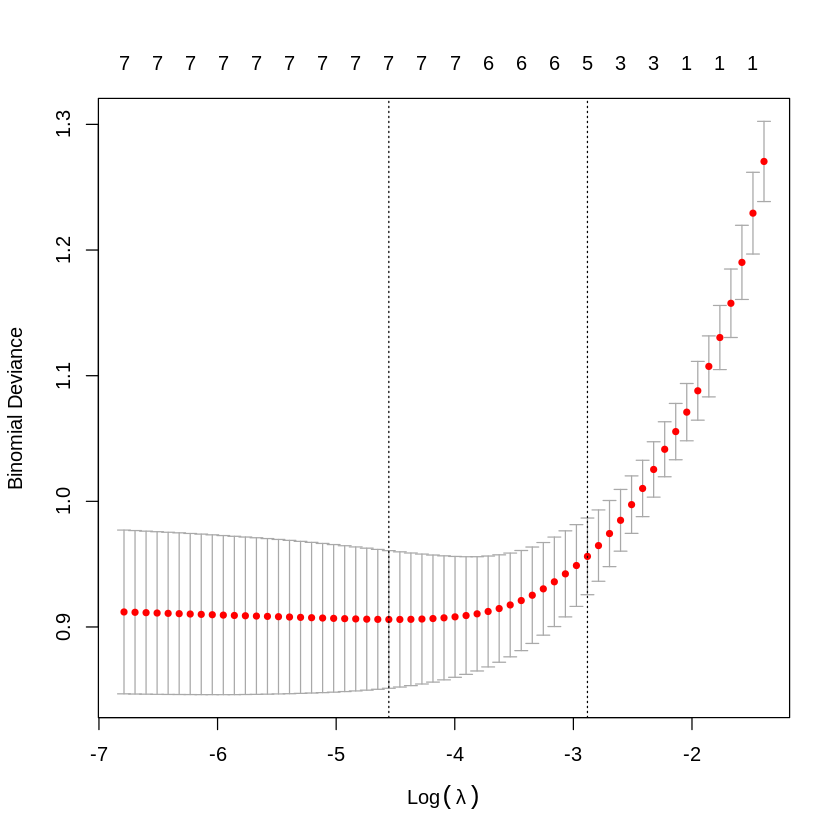

In [50]:
set.seed(123)
cv.lasso <- cv.glmnet(x, y, alpha = 1, family = "binomial", nfolds = 5)
plot(cv.lasso)

El gráfico muestra el error de validación cruzada en función del logaritmo de lambda. La línea vertical discontinua de la izquierda indica que el logaritmo del valor óptimo de lambda es aproximadamente -5, que es el que minimiza el error de predicción. Este valor de lambda dará el modelo más preciso. El valor exacto de lambda puede verse como sigue:

In [51]:
cv.lasso$lambda.min

[1] 0.01050424

En general, el objetivo de la regularización es equilibrar la precisión y la simplicidad. Es decir, un modelo con el menor número de predictores que también dé una buena precisión. Con este fin, la función cv.glmnet() encuentra también el valor de lambda que da el modelo más simple pero también se encuentra dentro de un error estándar del valor óptimo de lambda. Este valor se denomina lambda.1se.

In [52]:
cv.lasso$lambda.1se

[1] 0.05605795

Utilizando lambda.min como mejor lambda, se obtienen los siguientes coeficientes de regresión:

In [53]:
coef(cv.lasso, cv.lasso$lambda.min)

9 x 1 sparse Matrix of class "dgCMatrix"
                       s1
(Intercept) -9.3087021943
pregnant     0.0740061001
glucose      0.0342524179
pressure     .           
triceps      0.0111958547
insulin      0.0003163863
mass         0.0669046281
pedigree     1.0120379018
age          0.0261595958

Utilizando lambda.1se como mejor lambda, se obtienen los siguientes coeficientes de regresión:

In [54]:
coef(cv.lasso, cv.lasso$lambda.1se)

9 x 1 sparse Matrix of class "dgCMatrix"
                      s1
(Intercept) -5.863908146
pregnant     .          
glucose      0.026216289
pressure     .          
triceps      0.002763246
insulin      .          
mass         0.030660538
pedigree     0.149465488
age          0.021699005

En las secciones siguientes, calcularemos el modelo final utilizando lambda.min y, a continuación, evaluaremos la exactitud (accuracy) del modelo con los datos de prueba. También discutiremos los resultados obtenidos ajustando el modelo utilizando lambda = lambda.1se.

## Modelo LASSO final

Calculamos el modelo final utilizando lambda.min:

In [88]:
# Final model lasso with lambda.min
lasso.model <- glmnet(x, y, alpha = 1, family = "binomial",
                      lambda = cv.lasso$lambda.min)

# Make prediction on TRAIN
x.train <- model.matrix(diabetes ~., train.data)[,-1]
probabilities <- lasso.model %>% predict(newx = x.train)
predicted.classes <- ifelse(probabilities > 0.3, "pos", "neg")
# Model accuracy
observed.classes <- train.data$diabetes
print('ENTRENAMIENTO')
print(confusionMatrix(as.factor(predicted.classes),observed.classes))

# Make prediction on TEST
x.test <- model.matrix(diabetes ~., test.data)[,-1]
probabilities <- lasso.model %>% predict(newx = x.test)
predicted.classes <- ifelse(probabilities > 0.3, "pos", "neg")
# Model accuracy
observed.classes <- test.data$diabetes
print('PRUEBA')
print(confusionMatrix(as.factor(predicted.classes),observed.classes))

[1] "ENTRENAMIENTO"
Confusion Matrix and Statistics

          Reference
Prediction neg pos
       neg 193  49
       pos  17  55
                                          
               Accuracy : 0.7898          
                 95% CI : (0.7405, 0.8335)
    No Information Rate : 0.6688          
    P-Value [Acc > NIR] : 1.532e-06       
                                          
                  Kappa : 0.4856          
                                          
 Mcnemar's Test P-Value : 0.0001357       
                                          
            Sensitivity : 0.9190          
            Specificity : 0.5288          
         Pos Pred Value : 0.7975          
         Neg Pred Value : 0.7639          
             Prevalence : 0.6688          
         Detection Rate : 0.6146          
   Detection Prevalence : 0.7707          
      Balanced Accuracy : 0.7239          
                                          
       'Positive' Class : neg             
          

Calculamos el modelo final usando lambda.1se:

In [89]:
# Final lasso model with lambda.1se
lasso.model <- glmnet(x, y, alpha = 1, family = "binomial",
                      lambda = cv.lasso$lambda.1se)

# Make prediction on TRAIN
x.train <- model.matrix(diabetes ~., train.data)[,-1]
probabilities <- lasso.model %>% predict(newx = x.train)
predicted.classes <- ifelse(probabilities > 0.3, "pos", "neg")
# Model accuracy rate
observed.classes <- train.data$diabetes
print("ENTRENAMIENTO")
print(confusionMatrix(as.factor(predicted.classes),observed.classes))

# Make prediction on TEST
x.test <- model.matrix(diabetes ~., test.data)[,-1]
probabilities <- lasso.model %>% predict(newx = x.test)
predicted.classes <- ifelse(probabilities > 0.3, "pos", "neg")
# Model accuracy rate
observed.classes <- test.data$diabetes
print("PRUEBA")
print(confusionMatrix(as.factor(predicted.classes),observed.classes))

[1] "ENTRENAMIENTO"
Confusion Matrix and Statistics

          Reference
Prediction neg pos
       neg 199  64
       pos  11  40
                                          
               Accuracy : 0.7611          
                 95% CI : (0.7101, 0.8072)
    No Information Rate : 0.6688          
    P-Value [Acc > NIR] : 0.0002278       
                                          
                  Kappa : 0.3813          
                                          
 Mcnemar's Test P-Value : 1.92e-09        
                                          
            Sensitivity : 0.9476          
            Specificity : 0.3846          
         Pos Pred Value : 0.7567          
         Neg Pred Value : 0.7843          
             Prevalence : 0.6688          
         Detection Rate : 0.6338          
   Detection Prevalence : 0.8376          
      Balanced Accuracy : 0.6661          
                                          
       'Positive' Class : neg             
          

## Regresión RIDGE

Hallar el valor óptimo de lambda que minimice el error de validación cruzada

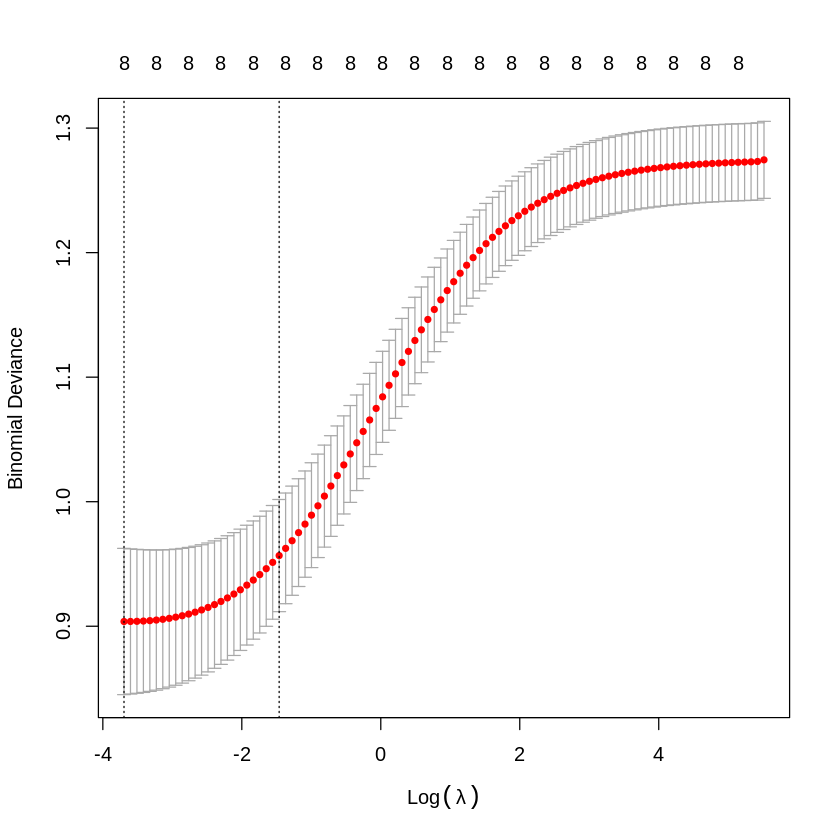

In [90]:
set.seed(123)
cv.ridge <- cv.glmnet(x, y, alpha = 0, family = "binomial", nfolds = 5)
plot(cv.ridge)

In [91]:
cv.ridge$lambda.min

[1] 0.02483716

In [18]:
cv.ridge$lambda.1se

[1] 0.2316322

In [19]:
coef(cv.ridge, cv.ridge$lambda.min)

9 x 1 sparse Matrix of class "dgCMatrix"
                      s1
(Intercept) -8.972141064
pregnant     0.080224115
glucose      0.028902902
pressure     0.003516291
triceps      0.017703983
insulin      0.001371375
mass         0.057840044
pedigree     1.016689886
age          0.026320355

In [20]:
coef(cv.ridge, cv.ridge$lambda.1se)

9 x 1 sparse Matrix of class "dgCMatrix"
                      s1
(Intercept) -5.525059819
pregnant     0.046849162
glucose      0.013612714
pressure     0.006989902
triceps      0.014214120
insulin      0.001607987
mass         0.027760209
pedigree     0.463049257
age          0.019198955

In [94]:
# Final ridge model with lambda.min
ridge.model <- glmnet(x, y, alpha = 0, family = "binomial",
                      lambda = cv.ridge$lambda.min)

# Make prediction on TRAIN
x.train <- model.matrix(diabetes ~., train.data)[,-1]
probabilities <- ridge.model %>% predict(newx = x.train)
predicted.classes <- ifelse(probabilities > 0.3, "pos", "neg")
# Model accuracy
observed.classes <- train.data$diabetes
print("ENTRENAMIENTO")
print(confusionMatrix(as.factor(predicted.classes),observed.classes))

# Make prediction on TEST
x.test <- model.matrix(diabetes ~., test.data)[,-1]
probabilities <- ridge.model %>% predict(newx = x.test)
predicted.classes <- ifelse(probabilities > 0.3, "pos", "neg")
# Model accuracy
observed.classes <- test.data$diabetes
print("PRUEBA")
print(confusionMatrix(as.factor(predicted.classes),observed.classes))

[1] "ENTRENAMIENTO"
Confusion Matrix and Statistics

          Reference
Prediction neg pos
       neg 196  48
       pos  14  56
                                          
               Accuracy : 0.8025          
                 95% CI : (0.7542, 0.8451)
    No Information Rate : 0.6688          
    P-Value [Acc > NIR] : 1.035e-07       
                                          
                  Kappa : 0.5142          
                                          
 Mcnemar's Test P-Value : 2.777e-05       
                                          
            Sensitivity : 0.9333          
            Specificity : 0.5385          
         Pos Pred Value : 0.8033          
         Neg Pred Value : 0.8000          
             Prevalence : 0.6688          
         Detection Rate : 0.6242          
   Detection Prevalence : 0.7771          
      Balanced Accuracy : 0.7359          
                                          
       'Positive' Class : neg             
          

In [95]:
# Final ridge model with lambda.1se
ridge.model <- glmnet(x, y, alpha = 0, family = "binomial",
                      lambda = cv.lasso$lambda.1se)

# Make prediction on TRAIN
x.train <- model.matrix(diabetes ~., train.data)[,-1]
probabilities <- ridge.model %>% predict(newx = x.train)
predicted.classes <- ifelse(probabilities > 0.3, "pos", "neg")
# Model accuracy rate
observed.classes <- train.data$diabetes
print("ENTRENAMIENTO")
print(confusionMatrix(as.factor(predicted.classes),observed.classes))

# Make prediction on TEST
x.test <- model.matrix(diabetes ~., test.data)[,-1]
probabilities <- ridge.model %>% predict(newx = x.test)
predicted.classes <- ifelse(probabilities > 0.3, "pos", "neg")
# Model accuracy rate
observed.classes <- test.data$diabetes
print("PRUEBA")
print(confusionMatrix(as.factor(predicted.classes),observed.classes))

[1] "ENTRENAMIENTO"
Confusion Matrix and Statistics

          Reference
Prediction neg pos
       neg 198  53
       pos  12  51
                                          
               Accuracy : 0.793           
                 95% CI : (0.7439, 0.8364)
    No Information Rate : 0.6688          
    P-Value [Acc > NIR] : 8.035e-07       
                                          
                  Kappa : 0.4811          
                                          
 Mcnemar's Test P-Value : 6.999e-07       
                                          
            Sensitivity : 0.9429          
            Specificity : 0.4904          
         Pos Pred Value : 0.7888          
         Neg Pred Value : 0.8095          
             Prevalence : 0.6688          
         Detection Rate : 0.6306          
   Detection Prevalence : 0.7994          
      Balanced Accuracy : 0.7166          
                                          
       'Positive' Class : neg             
          

## Redes ELASTIC NET

In [66]:
# aqui hago redes elasticas de 0.1 a 0.9
for (i in 1:9){
  assign(paste("found", i, sep=""), cv.glmnet(x, y, nfolds=5, alpha=i/10, family = "binomial"))}

In [67]:
min(cv.ridge$cvm)

[1] 0.9037892

In [68]:
min(found1$cvm)

[1] 0.8973633

In [69]:
min(found2$cvm)

[1] 0.9001325

In [70]:
min(found3$cvm)

[1] 0.9338918

In [28]:
min(found4$cvm)

[1] 0.9062029

In [29]:
min(found5$cvm)

[1] 0.9037187

In [30]:
min(found6$cvm)

[1] 0.9495413

In [31]:
min(found7$cvm)

[1] 0.9323531

In [32]:
min(found8$cvm)

[1] 0.9179567

In [33]:
min(found9$cvm)

[1] 0.9133484

In [34]:
min(cv.lasso$cvm)

[1] 0.905994

In [71]:
elastic3 <- glmnet(x, y, alpha = 0.1, family = "binomial")
coef(elastic3, s=found3$lambda.1se)

9 x 1 sparse Matrix of class "dgCMatrix"
                      s1
(Intercept) -4.864679218
pregnant     0.035819779
glucose      0.013456006
pressure     0.003945337
triceps      0.011442393
insulin      0.001307383
mass         0.023983657
pedigree     0.338073021
age          0.017513388

In [96]:
# Final elastic net model with lambda.min
elastic3 <- glmnet(x, y, alpha = 0.1, family = "binomial",
                      lambda = found3$lambda.min)

# Make prediction on TRAIN
x.train <- model.matrix(diabetes ~., train.data)[,-1]
probabilities <- elastic3 %>% predict(newx = x.train)
predicted.classes <- ifelse(probabilities > 0.3, "pos", "neg")
# Model accuracy
observed.classes <- train.data$diabetes
print("ENTRENAMIENTO")
print(confusionMatrix(as.factor(predicted.classes),observed.classes))

# Make prediction on TEST
x.test <- model.matrix(diabetes ~., test.data)[,-1]
probabilities <- elastic3 %>% predict(newx = x.test)
predicted.classes <- ifelse(probabilities > 0.3, "pos", "neg")
# Model accuracy
observed.classes <- test.data$diabetes
print("PRUEBA")
print(confusionMatrix(as.factor(predicted.classes),observed.classes))

[1] "ENTRENAMIENTO"
Confusion Matrix and Statistics

          Reference
Prediction neg pos
       neg 196  49
       pos  14  55
                                          
               Accuracy : 0.7994          
                 95% CI : (0.7507, 0.8422)
    No Information Rate : 0.6688          
    P-Value [Acc > NIR] : 2.089e-07       
                                          
                  Kappa : 0.5051          
                                          
 Mcnemar's Test P-Value : 1.839e-05       
                                          
            Sensitivity : 0.9333          
            Specificity : 0.5288          
         Pos Pred Value : 0.8000          
         Neg Pred Value : 0.7971          
             Prevalence : 0.6688          
         Detection Rate : 0.6242          
   Detection Prevalence : 0.7803          
      Balanced Accuracy : 0.7311          
                                          
       'Positive' Class : neg             
          

In [97]:
# Final elastic net model with lambda.1se
elastic3 <- glmnet(x, y, alpha = 0.1, family = "binomial",
                      lambda = found3$lambda.1se)

# Make prediction on TRAIN
x.train <- model.matrix(diabetes ~., train.data)[,-1]
probabilities <- elastic3 %>% predict(newx = x.train)
predicted.classes <- ifelse(probabilities > 0.3, "pos", "neg")
# Model accuracy
observed.classes <- train.data$diabetes
print("PRUEBA")
print(confusionMatrix(as.factor(predicted.classes),observed.classes))

# Make prediction on TEST
x.test <- model.matrix(diabetes ~., test.data)[,-1]
probabilities <- elastic3 %>% predict(newx = x.test)
predicted.classes <- ifelse(probabilities > 0.3, "pos", "neg")
# Model accuracy
observed.classes <- test.data$diabetes
print("PRUEBA")
print(confusionMatrix(as.factor(predicted.classes),observed.classes))

[1] "PRUEBA"
Confusion Matrix and Statistics

          Reference
Prediction neg pos
       neg 206  78
       pos   4  26
                                          
               Accuracy : 0.7389          
                 95% CI : (0.6866, 0.7866)
    No Information Rate : 0.6688          
    P-Value [Acc > NIR] : 0.004366        
                                          
                  Kappa : 0.2815          
                                          
 Mcnemar's Test P-Value : 7.536e-16       
                                          
            Sensitivity : 0.9810          
            Specificity : 0.2500          
         Pos Pred Value : 0.7254          
         Neg Pred Value : 0.8667          
             Prevalence : 0.6688          
         Detection Rate : 0.6561          
   Detection Prevalence : 0.9045          
      Balanced Accuracy : 0.6155          
                                          
       'Positive' Class : neg             
                 